In [100]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from functools import partial

In [101]:
@jax.jit
def psi(alpha, x):
    psi = jnp.exp(-alpha * x ** 2 / 2)
    return psi

In [102]:
log_prob = jax.jit(lambda alpha, x: 2 * jnp.log(psi(alpha, x)))

In [103]:
def mcmc_step(alpha, key, position, step_size):
    """
    A single step of the Metropolis-Hastings algorithm.
    """
    key, subkey = jax.random.split(key)
    # Sample a new position from the proposal distribution
    new_position = position + jax.random.normal(subkey, position.shape) * step_size
    # Compute the log-probability of the new position
    new_log_prob = log_prob(alpha, new_position)
    # Compute the log-probability of the old position
    old_log_prob = log_prob(alpha, position)
    # Compute the log-acceptance ratio
    log_acceptance_ratio = new_log_prob - old_log_prob
    # Accept or reject the new position
    key, subkey = jax.random.split(key)
    accept = jnp.log(jax.random.uniform(subkey, (position.shape[0],))) < log_acceptance_ratio
    return new_position * accept + position * (1 - accept), key

In [104]:
d2psi = jax.jit(jax.grad(jax.grad(psi, argnums=(1)), argnums=(1)))

In [105]:
local_energy = jax.jit(jax.vmap(lambda alpha, x:
    (-d2psi(alpha, x) / 2 + 1 / 2 * x ** 2 * psi(alpha, x)) / psi(alpha, x), in_axes=(None, 0)))

In [106]:
energy = jax.jit(lambda alpha, x: jnp.mean(local_energy(alpha, x)))
energy_grad = jax.jit(jax.grad(energy, argnums=(0)))

In [132]:
n_walkers = 1000
position = jnp.zeros((n_walkers,))
step_size = 0.1
n_steps = 30
burn_in = 10000
alpha = 2.0
key = jax.random.PRNGKey(42)
alpha_list = []
energy_list = []
energy_grad_list = []
for i in range(n_steps):
    for j in range(burn_in):
        position, key = mcmc_step(alpha, key, position, step_size)
    alpha_list.append(alpha)
    energy_list.append(energy(alpha, position))
    energy_grad_list.append(energy_grad(alpha, position))
    alpha -= 5 * jnp.exp(-i/50) * energy_grad(alpha, position)
    print(i, energy(alpha, position))

0 0.6335296
1 0.6200141
2 0.61365026
3 0.5855672
4 0.57048255
5 0.5964587
6 0.53747815
7 0.5238823
8 0.5672853
9 0.53217685
10 0.5337672
11 0.5085279
12 0.5211039
13 0.52364653
14 0.5193672
15 0.50529855
16 0.51739633
17 0.50546503
18 0.50110847
19 0.5008582
20 0.49848422
21 0.4995599
22 0.5031116
23 0.4965222
24 0.49049392
25 0.4996927
26 0.49838552
27 0.50052166
28 0.49006712
29 0.5033959


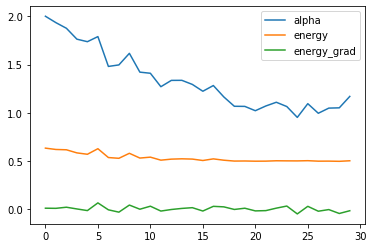

In [133]:
plt.plot(alpha_list, label='alpha')
plt.plot(energy_list, label='energy')
plt.plot(energy_grad_list, label='energy_grad')
plt.legend()
plt.show()